In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os 
import copy
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import matplotlib.ticker as mticker
from matplotlib import ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
import os

from scipy.signal import butter, lfilter
from scipy.signal import convolve

import utilities

import importlib
def reimport_module(module_name):
    """
    Reimports the specified Python module.
    
    Args:
    module_name (module): The module to be reimported, typically passed as a variable.
    
    Returns:
    module: The reloaded module.
    """
    try:
        # Reload the already imported module
        reloaded_module = importlib.reload(module_name)
        print(f"Module {module_name.__name__} reloaded successfully.")
        return reloaded_module
    except Exception as e:
        print(f"Failed to reload module: {e}")

reimport_module(utilities)
from sklearn import linear_model


Module utilities reloaded successfully.


## Vars In

In [2]:
Make_Tend = False
lev_do = 850

######################################################################
######################################################################
# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNTRLmjo_DT/ts/'
# f_precip_in = 'f.e.FTORCHmjo_CNTRLmjo_DT.cam.h1.PRECT.1979010100000-1990122200000.nc'
# var_name_precip = 'PRECT'

# f_u_in = 'f.e.FTORCHmjo_CNTRLmjo_DT.cam.h1.Q.1979010100000-1990122200000.nc'
# var_name_u = 'Q'
######################################################################
######################################################################

# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_fullCNN_DT/ts/'
# f_precip_in = 'f.e.FTORCHmjo_fullCNN_DT.cam.h1.PRECT.1979010100000-1990123100000.nc'
# var_name_precip = 'PRECT'

# f_u_in = 'f.e.FTORCHmjo_fullCNN_DT.cam.h1.Q.1979010100000-1990123100000.nc'
# var_name_u = 'Q'

######################################################################
######################################################################

dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/'
f_precip_in = 'f.e.FTORCHmjo_CNNmjo_DT.cam.h1.PRECT.1979010100000-1990122200000.nc'
var_name_precip = 'PRECT'

f_u_in = 'f.e.FTORCHmjo_CNNmjo_DT.cam.h1.Q.1979010100000-1990122200000.nc'
var_name_u = 'Q'

#####################################################################
######################################################################

# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo_DT/ts/'
# f_precip_in = 'f.e.FTORCHmjo_MEANmjo_DT.cam.h1.PRECT.1979010100000-1990122200000.nc'
# var_name_precip = 'PRECT'

# f_u_in = 'f.e.FTORCHmjo_MEANmjo_DT.cam.h1.U850.1979010100000-1990122200000.nc'
# var_name_u = 'U850'

######################################################################
######################################################################


dir_out = f'{dir_in}/mjo_diag/'
# Check if the directory exists
if not os.path.exists(dir_out):
    # Create the directory
    os.makedirs(dir_out)
    print(f"Directory {dir_out} created.")

save_Fig_out = f'{dir_out}/{f_precip_in.split(var_name_precip)[0]}REGRESS_MJO_TS_{var_name_precip}_{var_name_u}.png'
print(f'saving figure to {save_Fig_out}')
save_nc_out = f'{dir_out}/{f_precip_in.split(var_name_precip)[0]}REGRESS_MJO_TS_{var_name_precip}_{var_name_u}.nc'
print(f'saving figure to {save_nc_out}')

saving figure to /glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts//mjo_diag//f.e.FTORCHmjo_CNNmjo_DT.cam.h1.REGRESS_MJO_TS_PRECT_Q.png
saving figure to /glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts//mjo_diag//f.e.FTORCHmjo_CNNmjo_DT.cam.h1.REGRESS_MJO_TS_PRECT_Q.nc




## Region Setting:

In [3]:
lat_bounds_IO = slice(-10, 5)
lon_bounds_IO = slice(75, 100)
lat_bounds_global = slice(-30, 30)
latns = slice(-10, 10)   
lonlr = slice(80, 100)

# Define bandpass frequency limits
f_low = 100  # Corresponds to  days period
f_high = 20   # Corresponds to 20 days period
maxlag = 30

## Open Files

In [4]:
%%time
# precip: 
file_path_precip = os.path.join(dir_in, f_precip_in)  # Join the directory and file name
DS_precip = xr.open_dataset(file_path_precip)
DS_precip['time '] = DS_precip.indexes['time'].to_datetimeindex()
DS_precip = DS_precip.drop('time_bnds')
# u850: 
file_path_u = os.path.join(dir_in, f_u_in)  # Join the directory and file name
DS_u = xr.open_dataset(file_path_u)
DS_u['time '] = DS_u.indexes['time'].to_datetimeindex()

try:
    DS_u = DS_u.sel(lev=lev_do, method='nearest').squeeze()
    print('...loading...')
    DS_u = DS_u.load()
except:
    DS_u = DS_u


#create cosine latitude weighting: 
weights = np.cos(np.deg2rad(DS_u.lat))

...loading...
CPU times: user 1.13 s, sys: 37.2 s, total: 38.3 s
Wall time: 3min 38s


## Precip Indian Ocean:

gather the precipitation over the indian ocean in the typical region and apply a band 
pass filter

In [5]:
%%time
PIO = (DS_precip*weights).sel(lat = lat_bounds_IO, lon = lon_bounds_IO).mean(['lat','lon'])

##fft this time series: 
PIO_arr = np.array(PIO[var_name_precip])
mean_value = np.nanmean(PIO_arr)
PIO_arr[np.isnan(PIO_arr)] = mean_value
PIO_f = utilities.bandpass_filter_via_fft_1d(PIO_arr, f_high, f_low, sampling_interval=1)
PIO['PRECT_f'] = copy.deepcopy(PIO[var_name_precip])
PIO['PRECT_df'] = copy.deepcopy(PIO[var_name_precip])

PIO['PRECT_f'][:] = PIO_f
PIO['PRECT_df'][:] = utilities.detrend(PIO_f)

PIO['PRECT_f'].attrs = DS_precip[var_name_precip].attrs
PIO['PRECT_f'].attrs['long_name'] = 'Total precipitaption rate averaged over IO fft filtered'
PIO['PRECT_df'].attrs = DS_precip[var_name_precip].attrs
PIO['PRECT_df'].attrs['long_name'] = 'Total precipitaption rate averaged over IO, detrended, fft filtered'
PIO[var_name_precip].attrs = DS_precip[var_name_precip].attrs
PIO[var_name_precip].attrs['long_name'] = 'Total precipitaption rate averaged over IO'

CPU times: user 525 ms, sys: 2.02 s, total: 2.54 s
Wall time: 2.63 s


## Filter Variable Data

Do a 3d band-pass filtering on the target data

In [6]:
%%time
print('... starting filtering ...')
var_f = utilities.bandpass_filter_via_fft_3d(np.array(DS_u[var_name_u]), f_high, f_low, sampling_interval = 1)
DS_u['Var_f'] = (('time', 'lat', 'lon'), var_f)

... starting filtering ...
CPU times: user 14.5 s, sys: 2.08 s, total: 16.6 s
Wall time: 16.6 s


## Regress it!

first select winter time, and regress the signal

In [7]:
NDFJMA_PIO = PIO.where((PIO['time.month'] >= 11) | (PIO['time.month'] <= 5), drop=True)
NDFJMA_u = DS_u.where((DS_u['time.month'] >= 11) | (DS_u['time.month'] <= 5), drop=True)

In [8]:
%%time
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

mf = (NDFJMA_PIO['PRECT_f'].squeeze()*(86400*1000)).mean()
sdf = (NDFJMA_PIO['PRECT_f'].squeeze()*(86400*1000)).std()
print('standard deviation:',sdf.values)
print('mean:',mf.values)
prectgo = (NDFJMA_PIO['PRECT_f'].squeeze()*(86400*1000) - mf)/sdf

slopes = xr.apply_ufunc(linear_trend,
                        prectgo,  NDFJMA_u['Var_f'].sel(lat=slice(-25,25),lon=slice(20,220)),
                        vectorize=True,
                        input_core_dims=[['time'], ['time']],# reduce along 'time'
                        )

standard deviation: 1.4941042084288263
mean: -0.06005056699929863
CPU times: user 1.84 s, sys: 0 ns, total: 1.84 s
Wall time: 1.83 s


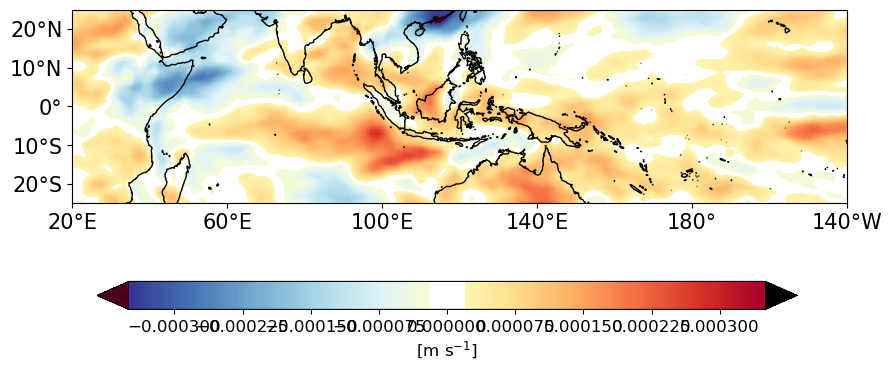

In [9]:

if var_name_u == 'MCBOT':
    # define the colormap
    cmap = plt.cm.RdYlBu_r
    # extract all colors from the Reds map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # make the first color entry to be whhite
    cmaplist[0] = cmap(1)
    # make the last color entry to be most extreme--
    cmaplist[cmap.N-1] = cmap(0.99)
    for ii in range(120,136):
        cmaplist[ii]=[1,1,1,1]
    cmap.N
    # create the new map
    cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
    clevels = np.arange(-2.5, 2.55, .05)*10e-8
    norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
    cmap.set_under([0.3, 0.00, 0.1, 1.0])
    cmap.set_over('k')
    cbar_lab ='[s$^{-1}$]'
elif var_name_u == 'TTEND_TOT':
    # define the colormap
    cmap = plt.cm.RdYlBu_r
    # extract all colors from the Reds map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # make the first color entry to be whhite
    cmaplist[0] = cmap(1)
    # make the last color entry to be most extreme--
    cmaplist[cmap.N-1] = cmap(0.99)
    for ii in range(120,136):
        cmaplist[ii]=[1,1,1,1]
    cmap.N
    # create the new map
    cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
    clevels = np.arange(-5.5, 5.55, .05)*10e-8
    norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
    cmap.set_under([0.3, 0.00, 0.1, 1.0])
    cmap.set_over('k')
    cbar_lab ='[K s$^{-1}$]'
elif var_name_u == 'U850':
    # define the colormap
    cmap = plt.cm.RdYlBu_r
    # extract all colors from the Reds map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # make the first color entry to be whhite
    cmaplist[0] = cmap(1)
    # make the last color entry to be most extreme--
    cmaplist[cmap.N-1] = cmap(0.99)
    for ii in range(120,136):
        cmaplist[ii]=[1,1,1,1]
    cmap.N
    # create the new map
    cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
    clevels = np.arange(-1.5, 1.55, .05)
    norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
    cmap.set_under([0.3, 0.00, 0.1, 1.0])
    cmap.set_over('k')
    cbar_lab ='[m s$^{-1}$]'
elif var_name_u == 'Q':
    # define the colormap
    cmap = plt.cm.RdYlBu_r
    # extract all colors from the Reds map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # make the first color entry to be whhite
    cmaplist[0] = cmap(1)
    # make the last color entry to be most extreme--
    cmaplist[cmap.N-1] = cmap(0.99)
    for ii in range(120,136):
        cmaplist[ii]=[1,1,1,1]
    cmap.N
    # create the new map
    cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
    clevels = np.arange(-3.5, 3.55, .05)*10e-5
    norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
    cmap.set_under([0.3, 0.00, 0.1, 1.0])
    cmap.set_over('k')
    cbar_lab ='[m s$^{-1}$]'

fig = plt.figure(figsize=(10, 14))  # Adjusted figure size for 8 panels
proj = ccrs.PlateCarree(central_longitude=180)
ax = plt.subplot(1, 1, 1, projection=proj)  # Dynamic subplot creation
ax.coastlines('50m')
bb = ax.contourf(slopes['lon'] - 180, slopes['lat'], slopes, levels=clevels, cmap=cmap, transform=proj, extend='both')

ax.set_xticks([20, 60, 100, 140, 180, 220, 260, 300, 340], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.0f'))
ax.set_yticks(np.arange(-60, 70, 10), crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_extent([20, 220, -25, 25], crs=ccrs.PlateCarree())
ax.tick_params(labelsize=15)


cbar_ax = fig.add_axes([0.15, 0.35, 0.7, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar=fig.colorbar(bb, cax=cbar_ax, orientation='horizontal', label='[m/d]')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label=cbar_lab,fontsize=12)
fig.subplots_adjust(hspace=-.12)  # Adjust spacing as needed
plt.savefig(save_Fig_out,bbox_inches='tight',dpi=400)
plt.show()
slopes.to_netcdf(save_nc_out)
